Best Parameters Found by GWO:
Depth: 9, Learning Rate: 0.2174, L2 Leaf Reg: 1.0469
Best MSE: 0.00015815326145267048

Final Model Performance:
MSE: 0.00013311184163974202
R²: 0.9983456399020377


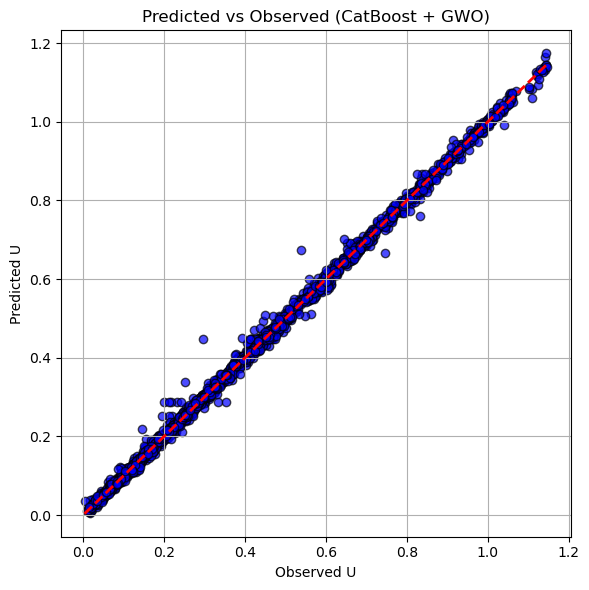

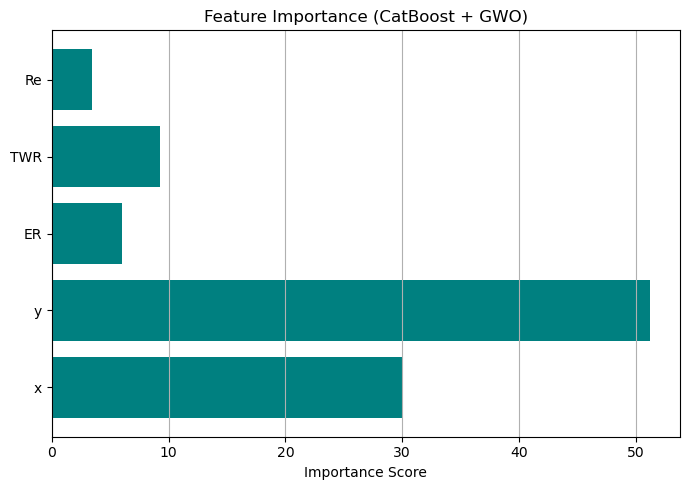

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

# -------------------------
# Load Data
# -------------------------
data = pd.read_csv("Udata.csv")
X = data.iloc[:, 0:5].values   # Features: X, Y, TWR, ER, Re
y = data.iloc[:, 5].values     # Label: U

# Split data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# -------------------------
# Gray Wolf Optimizer (GWO)
# -------------------------
class GWO:
    def __init__(self, obj_func, dim, lb, ub, n_agents=10, max_iter=20):
        self.obj_func = obj_func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_agents = n_agents
        self.max_iter = max_iter

    def optimize(self):
        wolves = np.random.uniform(self.lb, self.ub, (self.n_agents, self.dim))
        fitness = np.array([self.obj_func(w) for w in wolves])
        alpha, beta, delta = self._sort_wolves(wolves, fitness)

        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)
            for i in range(self.n_agents):
                for d in range(self.dim):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A1, C1 = 2*a*r1 - a, 2*r2
                    D_alpha = abs(C1*alpha[d] - wolves[i, d])
                    X1 = alpha[d] - A1*D_alpha

                    r1, r2 = np.random.rand(), np.random.rand()
                    A2, C2 = 2*a*r1 - a, 2*r2
                    D_beta = abs(C2*beta[d] - wolves[i, d])
                    X2 = beta[d] - A2*D_beta

                    r1, r2 = np.random.rand(), np.random.rand()
                    A3, C3 = 2*a*r1 - a, 2*r2
                    D_delta = abs(C3*delta[d] - wolves[i, d])
                    X3 = delta[d] - A3*D_delta

                    wolves[i, d] = np.clip((X1+X2+X3)/3, self.lb[d], self.ub[d])

            fitness = np.array([self.obj_func(w) for w in wolves])
            alpha, beta, delta = self._sort_wolves(wolves, fitness)

        return alpha, self.obj_func(alpha)

    def _sort_wolves(self, wolves, fitness):
        sorted_idx = np.argsort(fitness)
        return wolves[sorted_idx[0]], wolves[sorted_idx[1]], wolves[sorted_idx[2]]

# -------------------------
# Objective Function for GWO
# -------------------------
def objective(params):
    depth = int(params[0])
    lr = params[1]
    l2_leaf_reg = params[2]

    model = CatBoostRegressor(
        depth=depth,
        learning_rate=lr,
        l2_leaf_reg=l2_leaf_reg,
        iterations=300,
        silent=True,
        random_seed=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

# -------------------------
# Run GWO
# -------------------------
dim = 3
lb = [3, 0.01, 1]
ub = [10, 0.3, 10]

gwo = GWO(objective, dim, lb, ub, n_agents=8, max_iter=15)
best_params, best_score = gwo.optimize()

best_depth = int(best_params[0])
best_lr = best_params[1]
best_l2 = best_params[2]

print("Best Parameters Found by GWO:")
print(f"Depth: {best_depth}, Learning Rate: {best_lr:.4f}, L2 Leaf Reg: {best_l2:.4f}")
print("Best MSE:", best_score)

# -------------------------
# Train Final Model
# -------------------------
final_model = CatBoostRegressor(
    depth=best_depth,
    learning_rate=best_lr,
    l2_leaf_reg=best_l2,
    iterations=500,
    silent=True,
    random_seed=42
)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nFinal Model Performance:")
print("MSE:", mse)
print("R²:", r2)

# -------------------------
# Plot 1: Predicted vs. Observed
# -------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Observed U")
plt.ylabel("Predicted U")
plt.title("Predicted vs Observed (CatBoost + GWO)")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# Plot 2: Feature Importance
# -------------------------
feature_names = data.columns[0:5]
importances = final_model.get_feature_importance(Pool(X_train, y_train))

plt.figure(figsize=(7, 5))
plt.barh(feature_names, importances, color="teal")
plt.xlabel("Importance Score")
plt.title("Feature Importance (CatBoost + GWO)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()
